# Projet : Passive-Reflector
Nous rappelons l'objectif du projet : on veut montrer numériquement que la cross-corrélation de signaux émis par des sources bruitées et enregistrées par des récepteurs peuvent servir à localiser un réflecteur.<br> Nous commençons par inclure les bibliothèques dont on aura besoin. Parmi celles-ci se trouve utils qui correspond au .py joint à ce notebook qui contient les fonctions implémentées pour résoudre numériquement le problème.

In [1]:
%matplotlib inline

import utils as utils
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import warnings
warnings.filterwarnings("ignore")

Certains calculs (particulièrement les derniers avec la cross-correlation) sont longs. Nous mettons donc à disposition un boolean permettant de déterminer si les calculs seront fait ou non (notons que nous joignons des figures pour qu'il y a un affichage, malgré tout).

In [2]:
avoid_long_computation = False

Dans le projet, on part du même modèle que celui présenté au début du cours avec une solution de l'équation d'onde
$$ \frac{1}{c^2(x)}\frac{\partial^2 u}{\partial t^2} - \Delta_x u = n(t,x) $$
$n$ modélise le champs des bruits de source. Son auto-corrélation vaut
$$ \langle n(t_1,y_1); n(t_2,y_2)\rangle = F(t_2-t_1)\delta(y_1 - y_2)K(y_1) $$
Comme dans le cours, on retrouve la fonction temps-harmonique de Green $G_0$, solution fondamentale du \textbf{problème de Helmholtz} :
$$ \frac{\omega^2}{c^2(x)} \hat G_0 (\omega,x,y) - \nabla_x \hat G_0(\omega,x,y) = \delta(x,y) $$
Il en suit, 
$$ \hat G(\omega,x,y) = \hat G_0(\omega,x,y) + \sigma_r \omega^2 \hat G_0(\omega,x,z_r) \hat G_0(\omega,z_r,y)$$
Que l'on peut interpréter comme : $\hat G_0(\omega,x,y)$ onde émise de $y$ et reçu en $x$ et $\hat G_0(\omega,x,z) \hat G_0(\omega,z,y)$ est l'onde émise en $y$ réfléchie en $z$ et reçu en $x$. Cette approximation est appelée \textbf{approximation de Born}.

Nous initialisons le problèmes avec les grandeurs que nous utiliserons tout au long de la résolution du problème. Ici $N$ désigne le nombre de sources de positions $y$, étant amenées à émettre, $x$ désigne les positions des récepteurs qui enregistrent les signaux, $c_0$ la vitesse de propagation dans le milieu et $z_r$ la position du réflecteur. La dernière constante $\sigma_r$ sert à résoudre une approximation d'ordre 2 de $\hat G$ détaillée précédemment.

In [3]:
N = 200
y = utils.sample_ys(N)
x = utils.recevers_xs()
c_0 = 1
z_r = np.array([-5,0,65])
sigma_r = 10**(-3)

Chaque source $y_s$ émet un signal $n_s$ i.i.d. gaussien stationnaire de moyenne nulle et de covariance
$$ \langle n_s(t_1); n_s(t_2)\rangle = F(t_1-t_2) $$
Dans notre problème, $\hat F(\omega) = e^{-\omega^2}$. 

----

Dans la première partie, on étudie une première approximation de l'espérance de la cross-correlation empirique $C(\tau,x_1,x_2)$ définit par
$$ C(\tau,x_1,x_2) = \frac{1}{2\pi}\int \int K(y)\hat F(\omega) \overline{\hat G(\omega,x_1,y)} \hat G(\omega,x_2,y) e^{-i\omega \tau} dy d\omega $$
C'est approximation que l'on note $C_N$ est définit par 
$$ C_N(\tau,x_1,x_2) = \frac{1}{2\pi N}\sum_{s =1}^N \int \hat F(\omega) \overline{\hat G(\omega,x_1,y)} \hat G(\omega,x_2,y) e^{-i\omega \tau} d\omega $$

## 1.a) 
On commence par calculer et afficher $$ \tau \rightarrow C_N(\tau, x_5,x_1) $$
pour $\tau \in [-200;200]$.

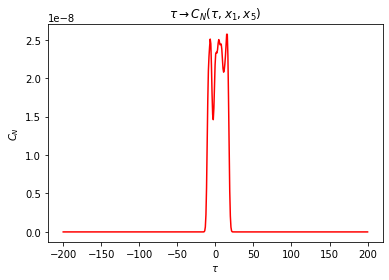

In [4]:
tau = np.linspace(-200,200,500)
f = utils.C_N(tau, x[4], x[0], y, c_0, z_r, sigma_r)
plt.plot(tau, f, 'r-')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$C_N$')
plt.title(r'$\tau \rightarrow C_N(\tau,x_1,x_5)$')
plt.show()

Certains petits pics sont masqués par la valeur centrale, on décide donc d'afficher également 
$$ \tau \rightarrow C_N(\tau, x_5,x_1)1_{\mathbb{R}\backslash [-50;50]} $$
sur le meme intervalle.

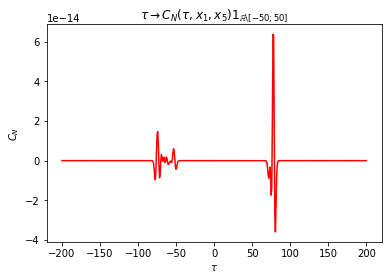

In [5]:
f = np.concatenate([f[:200], np.zeros(100), f[-200:]])
plt.plot(tau, f, 'r-')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$C_N$')
plt.title(r'$\tau \rightarrow C_N(\tau,x_1,x_5)1_{\mathbb{R}\backslash[-50;50]}$')
plt.show()

## 1.b)
On calcule ensuite l'image KM $\mathcal{I}_N (y^S)$ avec $y^S$ un candidat à la position du réflecteur. Cette image est alors définit par
$$ \mathcal{I}_N (y^S) = \sum_{k,l =1}^5 C_N(|x_k - y^S| + |x_l-y^S|, x_k, x_l) $$

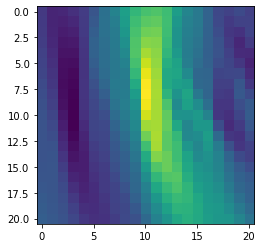

In [6]:
w_size = 10
dx = np.arange(2*w_size+1) - w_size
y_S = z_r + [0, 0, 1] * dx[:,None] + [1, 0, 0] * dx[:,None,None]
Im = utils.KM(y_S, x, y, c_0, z_r, sigma_r)
plt.imshow(Im)
plt.show()

## 1.c) 
Pour l'analyse de la résolution de l'image nous avons utilisé un résultat du polycopié. En effet, section 2.3.9 : "The resolution analysis of the Reverse-Time imaging function and the Kirch- hoff Migration imaging function goes along the same way as for passive source imaging". Ainsi
$$ R = \frac{N\max I^2}{\|I\|^2} $$

In [7]:
R = utils.etude_resolution(Im)
print("Resolution de l'image KM de I_N : " + str(R))

Resolution de l'image KM de I_N : 8.811685419758772


On observe tout d'abord que le pic est bien centré, comme l'image, sur la position du réflecteur ce qui indique un bon fonctionnement de la méthode. De plus, le score de la résolution est relativement élevé ce qui indique la possibilité d'une localisation précise.

-----

Dans ce qui suit nous allons nous intéresser à une seconde approximation de $C$ qui est une approximation de $C_N$, reposant sur le calcul de la cross-correlation empirique $C_{T,N}$ définit par
$$ C_{T,N}(\tau, x_1, x_2) = \frac{1}{T - |\tau|} \int_0^{T-|\tau|} u(t,x_1)u(t+\tau,x_2)dt $$
avec
$$ u(t,x) = \frac{1}{2\pi \sqrt{N}}\sum_{s=1}^N \int \hat G(\omega, x, y_s) \hat n_s(\omega) e^{-i\omega t} d\omega $$

## 2.a
Comme précédemment, on commence par afficher
$$ \tau \rightarrow C_{T,N}(\tau, x_5,x_1) $$
pour $\tau \in [-150;150]$. Mais cette fois-ci pour plusieurs valeurs de $T$.

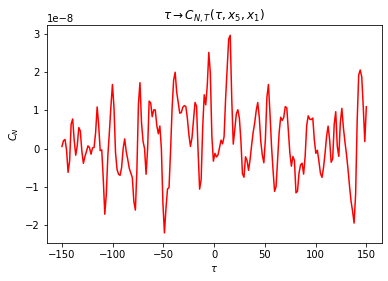

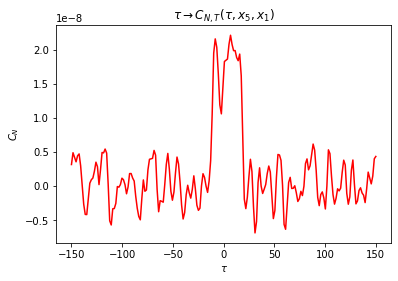

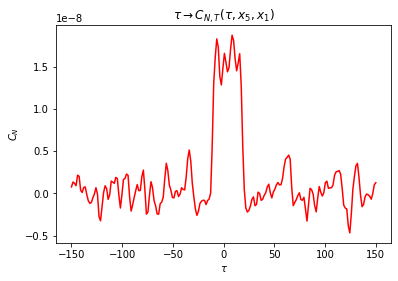

In [8]:
tau_values = np.linspace(-150,150,200)
T_values = [500, 5000, 20000]
if avoid_long_computation:
    for i,T in enumerate(T_values):
        display(Image(filename="figs/plot tau -> C_NT(tau,x_5,x_1) " + str(T) + ".png"))
    
else:
    for i,T in enumerate(T_values):
        plt.figure(i)
        f = utils.C_TNm(tau_values, x[4], x[0], T, y, c_0, z_r, sigma_r)
        plt.plot(tau_values, f, 'r-')
        plt.xlabel(r'$\tau$')
        plt.ylabel(r'$C_N$')
        plt.title(r'$\tau \rightarrow C_{N,T}(\tau,x_5,x_1)$')
    plt.show()

Afin d'augmenter la stabilité et puisque le résultat obtenu dépend du tirage de $n_s$, on peut considérer $M$ tirages de $C_{T,N}$ i.i.d. et ainsi étudier
$$ C_{T,N,M} = \frac{1}{M}\sum_{m=1}^M C_{T,N}^{(m)} $$

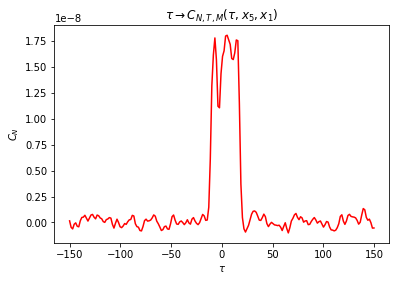

In [9]:
if avoid_long_computation:
    display(Image(filename="figs/plot tau -> C_NTM(tau,x_5,x_1) 10000.png"))
else:
    f = utils.C_TNM(20, tau_values, x[4], x[0], 10000, y, c_0, z_r, sigma_r)
    plt.plot(tau_values, f, 'r-')
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$C_N$')
    plt.title(r'$\tau \rightarrow C_{N,T,M}(\tau,x_5,x_1)$')
    plt.show()

On retrouve bien une valeur approchée de l'espérance de la cross-correlation. Cependant, sur l'ensemble $\mathbb{R}\backslash[-50;50]$ la nouvelle approximation est très bruitée.

## 2.b
Afin d'étudier la qualité des résultats obtenus par cette seconde approche, on calcule ensuite l'image KM $\mathcal{I}_{T,N,M} (y^S)$ avec $y^S$ un candidat à la position du réflecteur. Cette image est alors définit par
$$ \mathcal{I}_{T,N,M} (y^S) = \sum_{k,l =1}^5 C_{T,N,M}(|x_k - y^S| + |x_l-y^S|, x_k, x_l) $$

Realization: 10/10


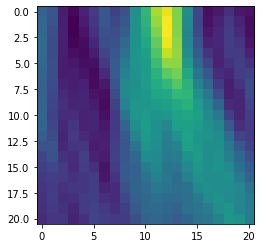

In [10]:
if avoid_long_computation:
    display(Image(filename="figs/image KM de I_NT.png"))
else:
    w_size = 10
    dx = np.arange(2*w_size+1) - w_size
    y_S = z_r + [0, 0, 1] * dx[:,None] + [1, 0, 0] * dx[:,None,None]
    Im = utils.KMT(y_S, x, y, 8000, 10, c_0, z_r, sigma_r)
    plt.imshow(Im)
    plt.show()

On obtient une image clairement plus bruitée que celle de la première partie. Il nous semble que cela est du au fait que l'information sur le réflecteur est contenu dans les pics de 
$$ \tau \rightarrow C_N(\tau, x_5,x_1)1_{\mathbb{R}\backslash [-50;50]} $$
or dans les cas de $C_{T,N}$ et $C_{T,N,M}$ on a clairement plus de bruit que d'information.

## 2.c
Malgré le fait que l'image précédente ne permet pas de localiser le réflecteur, on calcule tout de même la résolution de l'image.

In [11]:
if avoid_long_computation:
    print("On a besoin de l'image KM pour calculer la résolution or ce calcul est long !\n\n\t pour calculer la résolution : recommencer avec \n\t\tavoid_long_computation = False")
else:
    R = utils.etude_resolution(Im)
    print("Resolution de l'image KM de I_NT: " + str(R))

Resolution de l'image KM de I_NT: 9.291553448483059
